In [1]:
# Importing needed libraries
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
from PIL import Image

2025-07-15 10:41:09.127350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752576069.305027      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752576069.353644      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# to load the data from Kaggle and having a copy of it that is editable to remove corrupted images
import shutil
source_data_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'
distination_Data_path = '/kaggle/working/garbage-dataset'

shutil.copytree(source_data_path, distination_Data_path)

'/kaggle/working/garbage-dataset'

In [3]:
# splitting data to training, val, and test
from pathlib import Path
import random

old_dir = Path(distination_Data_path)
new_dir = Path('/kaggle/working/garbage-dataset-splitted')
trainval_dir = new_dir / 'training_and_validation'
test_dir = new_dir / 'test'

test_ratio = 0.1
random.seed(42)

for current_class in old_dir.iterdir():
    if current_class.is_dir():
        images = list(current_class.glob('*.*'))
        # random.shuffle(images)

        splitting_idx = int(len(images) * (1 - test_ratio))
        trainval_images = images[:splitting_idx]
        test_images = images[splitting_idx:]

        (trainval_dir / current_class.name).mkdir(parents=True, exist_ok=True)
        (test_dir / current_class.name).mkdir(parents=True, exist_ok=True)

        for img in trainval_images:
            shutil.copy(img, (trainval_dir / current_class.name / img.name))
        for img in test_images:
            shutil.copy(img, (test_dir / current_class.name / img.name))

    print(f"images of class {current_class.name} splitted successfully")

images of class shoes splitted successfully
images of class glass splitted successfully
images of class cardboard splitted successfully
images of class paper splitted successfully
images of class metal splitted successfully
images of class clothes splitted successfully
images of class trash splitted successfully
images of class biological splitted successfully
images of class battery splitted successfully
images of class plastic splitted successfully


In [5]:
# connecting to drive
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/MyDrive/NTI project/garbage-dataset'
# test_path = '/content/drive/MyDrive/NTI project/test_ds'

In [4]:
# data_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'   # old data path

# NOW data is prepared to be preprocessed in Kaggle
training_validation_path = "/kaggle/working/garbage-dataset-splitted/training_and_validation"
test_path = "/kaggle/working/garbage-dataset-splitted/test"

In [5]:
# checking the validity of data paths and the number of files in each class

for classes in os.listdir(training_validation_path):
  class_path = os.path.join(training_validation_path, classes)
  # print(class_path)
  if os.path.isdir(class_path):
    files = os.listdir(class_path)
    print(f"{classes}: {len(files)} files")

print('----------------------------------------------------------------------')      

for classes in os.listdir(test_path):
  class_path = os.path.join(test_path, classes)
  # print(class_path)
  if os.path.isdir(class_path):
    files = os.listdir(class_path)
    print(f"{classes}: {len(files)} files")

shoes: 1779 files
glass: 2754 files
cardboard: 1642 files
paper: 1512 files
metal: 918 files
clothes: 4794 files
trash: 852 files
biological: 897 files
battery: 849 files
plastic: 1785 files
----------------------------------------------------------------------
shoes: 198 files
glass: 307 files
cardboard: 183 files
paper: 168 files
metal: 102 files
clothes: 533 files
trash: 95 files
biological: 100 files
battery: 95 files
plastic: 199 files


In [7]:
# checking for non-image files

valid_extensions = ('.jpg','.png','.jepg','jpeg')

for classes in os.listdir(training_validation_path):
  class_path = os.path.join(training_validation_path, classes)
  if os.path.isdir(class_path):
    for current_file in os.listdir(class_path):
      if not current_file.lower().endswith(valid_extensions):
        print(f"{current_file} is not an image")

# no non-image files detected

In [8]:
#checking for corrupted files

from PIL import Image

corrupted_images = []

for classes in os.listdir(training_validation_path):
  class_path = os.path.join(training_validation_path, classes)
  if os.path.isdir(class_path):
    for corrent_file in os.listdir(class_path):
      file_path = os.path.join(class_path, corrent_file)
      try :
        with Image.open(file_path) as img :
          img.verify()  #verify if image can be oppened or not
      except (IOError, SyntaxError) as e:
        print(f"corrupted file : {file_path}")
        corrupted_images.append(file_path)

# No corrupted files are found using PIL

In [6]:
#checking for corrupted files using tensorflow
bad_files =[]

for classes in os.listdir(training_validation_path):
  class_path = os.path.join(training_validation_path, classes)
  if os.path.isdir(class_path):
    for corrent_file in os.listdir(class_path):
      file_path = os.path.join(class_path, corrent_file)
      try:
        img_raw = tf.io.read_file(file_path)
        img_tensor = tf.io.decode_image(img_raw, channels=3, expand_animations=False)
      except Exception as e:
        print(f"TensorFlow failed to load the file:{file_path}, error: {e}")
        bad_files.append(file_path)

bad_files
# Found two corrupted files

I0000 00:00:1752576399.933035      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


TensorFlow failed to load the file:/kaggle/working/garbage-dataset-splitted/training_and_validation/paper/paper_3119.jpg, error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
TensorFlow failed to load the file:/kaggle/working/garbage-dataset-splitted/training_and_validation/paper/paper_2784.jpg, error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


['/kaggle/working/garbage-dataset-splitted/training_and_validation/paper/paper_3119.jpg',
 '/kaggle/working/garbage-dataset-splitted/training_and_validation/paper/paper_2784.jpg']

In [7]:
#checking for corrupted files using tensorflow
bad_files_test =[]

for classes in os.listdir(test_path):
  class_path = os.path.join(test_path, classes)
  if os.path.isdir(class_path):
    for corrent_file in os.listdir(class_path):
      file_path = os.path.join(class_path, corrent_file)
      try:
        img_raw = tf.io.read_file(file_path)
        img_tensor = tf.io.decode_image(img_raw, channels=3, expand_animations=False)
      except Exception as e:
        print(f"TensorFlow failed to load the file:{file_path}, error: {e}")
        bad_files_test.append(file_path)

bad_files_test

#Found one corruoted files in the test data

TensorFlow failed to load the file:/kaggle/working/garbage-dataset-splitted/test/paper/paper_1678.jpg, error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


['/kaggle/working/garbage-dataset-splitted/test/paper/paper_1678.jpg']

In [8]:
# deleting currupted images

# can NOT remove images from these dataset as it is readonly

for corrupted_images in bad_files:
  try:
    os.remove(corrupted_images)
    print(f"{corrupted_images} is removed")
  except Exception as e:
    print(f"failed to remove {corrupted_images}, error: {e}\n")

for corrupted_images in bad_files_test:
  try:
    os.remove(corrupted_images)
    print(f"{corrupted_images} is removed")
  except Exception as e:
    print(f"failed to remove {corrupted_images}, error: {e}\n")

/kaggle/working/garbage-dataset-splitted/training_and_validation/paper/paper_3119.jpg is removed
/kaggle/working/garbage-dataset-splitted/training_and_validation/paper/paper_2784.jpg is removed
/kaggle/working/garbage-dataset-splitted/test/paper/paper_1678.jpg is removed


In [9]:
#Loading clear data
data_dir = '/kaggle/working/garbage-dataset-splitted/training_and_validation'
test_dir = '/kaggle/working/garbage-dataset-splitted/test'

for classes in os.listdir(data_dir):
  class_path = os.path.join(data_dir, classes)
  # print(class_path)
  if os.path.isdir(class_path):
    files = os.listdir(class_path)
    print(f"{classes}: {len(files)} files") # the output shows that the paper data has lost 2 images (recheck the above cell to ensure that)

shoes: 1779 files
glass: 2754 files
cardboard: 1642 files
paper: 1510 files
metal: 918 files
clothes: 4794 files
trash: 852 files
biological: 897 files
battery: 849 files
plastic: 1785 files


In [10]:
# Splitting data
train_ds = tf.keras.preprocessing.image_dataset_from_directory (
    data_dir,
    subset = 'training',
    batch_size = 32,
    image_size = (180,180),
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    interpolation='nearest'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory (
    data_dir,
    subset = 'validation',
    batch_size = 32,
    image_size = (180,180),
    shuffle = False,
    seed = 123,
    validation_split = 0.2,
    interpolation='nearest'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory (
    test_dir,
    batch_size = 32,
    image_size = (180,180),
    shuffle = False,
    seed = 123,
    interpolation='nearest'
)

Found 17780 files belonging to 10 classes.
Using 14224 files for training.
Found 17780 files belonging to 10 classes.
Using 3556 files for validation.
Found 1979 files belonging to 10 classes.


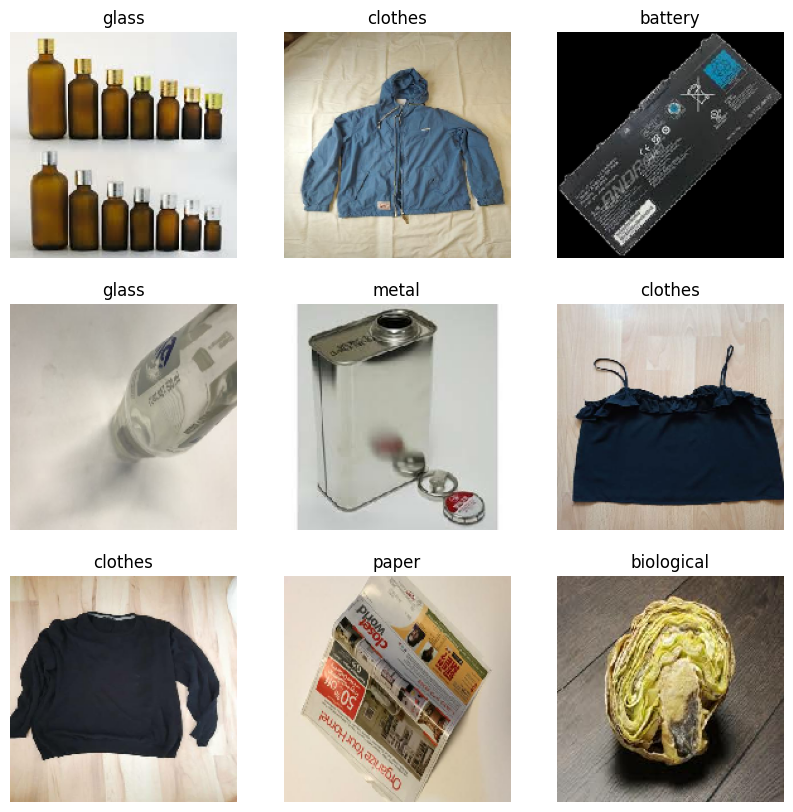

In [12]:
#visualising data
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [13]:
# preprocessing

#normalization
normalization = tf.keras.layers.Rescaling(1.0/255)

train_ds = train_ds.map(lambda x, y: (normalization(x),y))
val_ds = val_ds.map(lambda x,y:(normalization(x),y))
test_ds = test_ds.map(lambda x,y:(normalization(x),y))

#augmentaion

augmentation = tf.keras.Sequential([
    # layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomFlip('Horizental'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x,y: (augmentation(x, training=True),y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [17]:
# Model construction and training

model = tf.keras.Sequential ([
    # first convlution layer
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.AveragePooling2D(pool_size=2, strides=2),

    #second convolution layer
    # layers.Conv2D(32, kernel_size=3),
    # layers.BatchNormalization(),
    # layers.ReLU(),
    # layers.AveragePooling2D(pool_size=2, strides=2),
    
    # layers.Conv2D(64, kernel_size=3, activation='relu'),
    # layers.AveragePooling2D(pool_size=2, strides=1),

    #third convlutional layer
    # layers.Conv2D(64, kernel_size=3, activation='relu'),
    # layers.AveragePooling2D(pool_size=2, strides=1),

    #flattening the features
    layers.Flatten(),

    #fully connected layers
    # layers.Dense(1024, activation='relu'),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.ReLU(),
    # layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    # layers.Dense(128, activation='relu'),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [18]:
# model compilation and training
optimizer = Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=30)


Epoch 1/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 107s 217ms/step - accuracy: 0.3697 - loss: 1.8815 - val_accuracy: 0.0458 - val_loss: 2.7516
Epoch 2/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step - accuracy: 0.4946 - loss: 1.4586 - val_accuracy: 0.2641 - val_loss: 2.0234
Epoch 3/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 95s 213ms/step - accuracy: 0.5278 - loss: 1.3635 - val_accuracy: 0.2430 - val_loss: 1.9938
Epoch 4/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 95s 213ms/step - accuracy: 0.5644 - loss: 1.2797 - val_accuracy: 0.3729 - val_loss: 1.6430
Epoch 5/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 94s 212ms/step - accuracy: 0.5958 - loss: 1.1899 - val_accuracy: 0.3535 - val_loss: 1.7233
Epoch 6/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 94s 211ms/step - accuracy: 0.6110 - loss: 1.1490 - val_accuracy: 0.5591 - val_loss: 1.2131
Epoch 7/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 94s 210ms/step - accuracy: 0.6238 - loss: 1.1208 - val_accuracy: 0.3850 - val_loss: 1.7565
Epoch 8/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 95s 212ms/step - accuracy: 0.6425 - loss: 

In [19]:
history = model.history

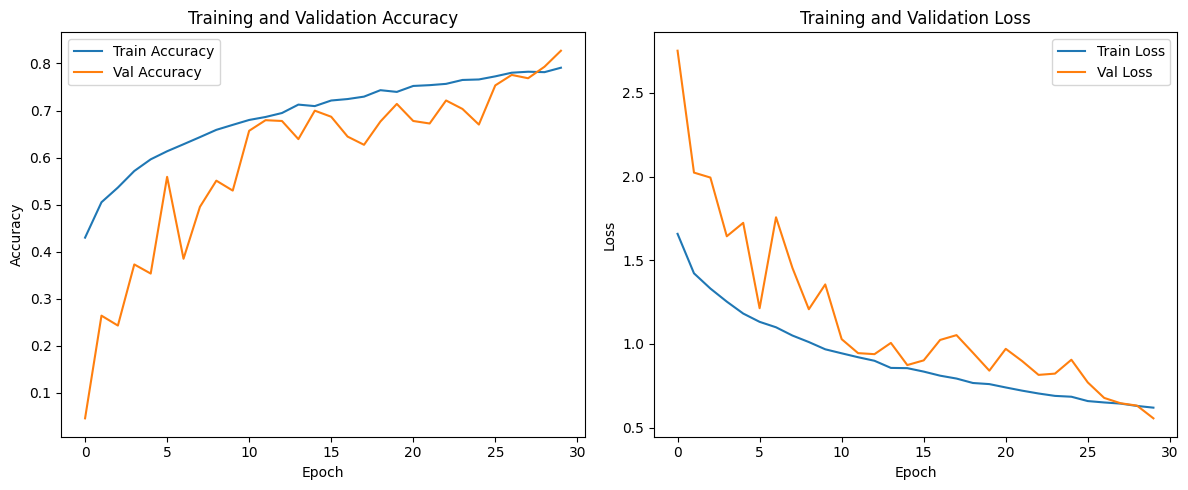

In [20]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
model.evaluate(test_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7333 - loss: 0.8118


[0.8661845326423645, 0.7190500497817993]

In [23]:
model.save("model_2_30epoch_acc78.keras")